In [18]:
import pandas as pd
import networkx as nx
import tqdm
from causaldata import social_insure
from pgmpy.estimators.CITests import pillai_trace
from dowhy.causal_identifier import backdoor

df: pd.DataFrame = social_insure.load_pandas().data.dropna()

In [19]:
# Drop fields 'address'
df = df.drop(columns=['address'])

# From social insurance, take takeup_survey
takeup_survey = df['takeup_survey']

## Convert labels to categorical variables

In [20]:
categorical_variables = ['village']
for var in categorical_variables:
    df[var] = df[var].astype('category').cat.codes


# 2.1 Testing correlation / dependence between variables

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


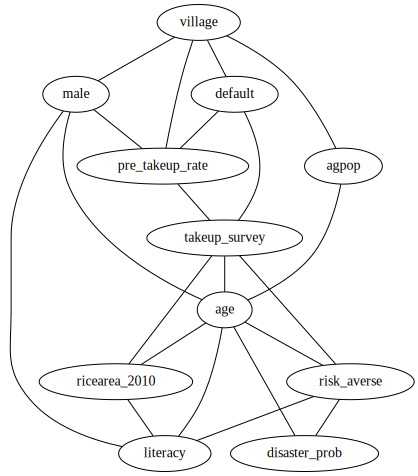

In [15]:
# For each other variable, calculate the p value of the correlation with takeup_survey
graph1: dict[str, dict[str, bool]] = {}

# Double for loop to compute pillai_trace between each pair of columns
for col1 in tqdm.tqdm(df.columns):
    graph1[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
            continue
        graph1[col1][col2] = pillai_trace(col1, col2, Z=[], data=df, significance_level=0.05)

# Create a graph from the p values
G1 = nx.Graph()
for col1 in graph1:
    for col2 in graph1[col1]:
        p_value = graph1[col1][col2]
        if not p_value:
            G1.add_edge(col1, col2)


A = nx.nx_agraph.to_agraph(G1)
A.layout('dot')
A

As can be seen in the above image, the causal links calculated make sense. For example,
 - `age` and `disaster probability` have in no way any correlation.
 - `village` and `male` are uncorrelated.

# 2.2 Casual graph
As the true causal graph is unknown, we cooked something up which made sense.

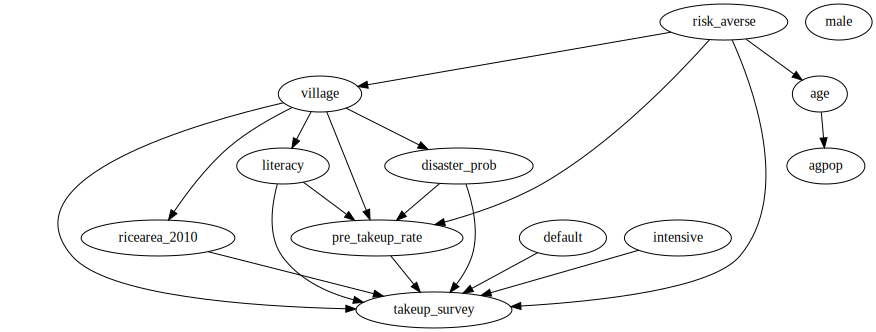

In [16]:
TG = nx.DiGraph()
TG.add_nodes_from(df.columns)
TG.add_edges_from([
    ('village', 'takeup_survey'),
    ('ricearea_2010', 'takeup_survey'),
    ('disaster_prob', 'takeup_survey'),
    ('default', 'takeup_survey'),
    ('intensive', 'takeup_survey'),
    ('risk_averse', 'takeup_survey'),
    ('literacy', 'takeup_survey'),
    ('pre_takeup_rate', 'takeup_survey'),
    ('risk_averse', 'pre_takeup_rate'),
    ('village', 'pre_takeup_rate'),
    ('disaster_prob', 'pre_takeup_rate'),
    ('literacy', 'pre_takeup_rate'),
    ('village', 'literacy'),
    ('village', 'ricearea_2010'),
    ('village', 'disaster_prob'),
    ('risk_averse', 'village'),
    ('risk_averse', 'age'),
    ('age', 'agpop')
])

A = nx.nx_agraph.to_agraph(TG)
A.layout('dot')
A

# 3. Backdoor, Frontdoor and Instrumental Variables Criteria

In [22]:
# Calculate all possible paths
all_paths = list(nx.all_simple_paths(TG, source='risk_averse', target='takeup_survey'))

### Backdoor Criterion

In [23]:
# First do backdoor criterion
bd = backdoor.Backdoor(TG, 'risk_averse', 'takeup_survey')

# Check for backdoors
bd_paths = [path for path in all_paths if bd.is_backdoor(path)]
for path in bd_paths:
    print("Backdoor path found:", path)

### Frontdoor Criterion

In [ ]:
from dowhy.causal_identifier import identify_effect
from dowhy import CausalModel

nx.write_gml(TG, "causal_graph.gml")
gml_graph = ""
with open("causal_graph.gml", "r") as f:
    for line in f:
        gml_graph += line.rstrip()

model = CausalModel(
    data=df,
    treatment='risk_averse',
    outcome='takeup_survey',
    graph=TG
)

print(model.identify_effect())

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['risk_averse'] on outcome ['takeup_survey']
INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


AttributeError: module 'networkx.algorithms' has no attribute 'find_minimal_d_separator'